# News Classification 📰

## Installs 🖥️

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 33.7 MB/s eta 0:00:00


In [2]:
!pip install torch==1.12.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.12.1 which is incompatible.
torchvision 0.19.0+cu121 requires torch==2.4.0, but you have torch 1.12.1 which is incompatible.


In [3]:
!pip install torchdata==0.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 58.3 MB/s eta 0:00:00


In [4]:
!pip install torchtext==0.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.4.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchvision 0.19.0+cu121 requires torch==2.4.0, but you have torch 1.12.0 which is incompatible.


## Imports 🧰

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
print(torch.__version__)
print(torchtext.__version__)

1.12.0+cu102
0.13.0


## Dataset 📖

### Load Dataset 📡

In [7]:
train_iter, test_iter = AG_NEWS(root='./dataset', split=('train', 'test'))

In [8]:
train_iter, test_iter

(ShardingFilterIterDataPipe, ShardingFilterIterDataPipe)

### Tokenize and Vocab 📝

In [9]:
tokenizer = get_tokenizer('basic_english')
tokenizer

<function torchtext.data.utils._basic_english_normalize(line)>

In [10]:
vocab = GloVe('6B', dim=50)
vocab

.vector_cache/glove.6B.zip: 862MB [02:46, 5.16MB/s]                           
100%|█████████▉| 399999/400000 [00:10<00:00, 38293.19it/s]


### DataLoader 📚

In [11]:
def collate(batch):
  labels = torch.LongTensor([b[0] for b in batch]) - 1
  text = [b[1]for b in batch]
  tokens = [tokenizer(t) for t in text]
  vecs = [vocab.get_vecs_by_tokens(token) for token in tokens]
  vecs = nn.utils.rnn.pad_sequence(vecs)
  return vecs, labels

In [12]:
train_loader = DataLoader(train_iter, batch_size=128, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_iter, batch_size=256, shuffle=True, collate_fn=collate)

In [13]:
t_iter = iter(train_loader)

In [14]:
x, y = next(t_iter)
x.shape, y

(torch.Size([139, 128, 50]),
 tensor([2, 3, 2, 3, 2, 0, 0, 1, 3, 3, 1, 2, 0, 1, 2, 1, 1, 3, 0, 1, 1, 3, 0, 1,
         0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 3, 2, 2, 3, 3, 2, 2, 1, 1, 3, 1, 3, 2,
         2, 1, 3, 2, 0, 3, 3, 2, 0, 3, 3, 0, 0, 0, 0, 1, 0, 2, 3, 1, 0, 1, 3, 2,
         2, 2, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 1, 2,
         0, 0, 0, 1, 0, 3, 2, 3, 3, 1, 2, 3, 2, 1, 0, 3, 1, 2, 3, 1, 1, 1, 3, 0,
         2, 2, 1, 2, 3, 1, 3, 3]))

## Init ✏️

In [15]:
num_cls = 4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Utils ⚙️

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

## Functions 🗝️

In [18]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [19]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_cls).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Model 🧠

In [20]:
class RNNModel(nn.Module):

  def __init__(self, RNN, input_size, hidden_size, num_layers, num_cls):
    super().__init__()
    self.rnn = RNN(input_size = input_size,
                   hidden_size = hidden_size,
                   num_layers = num_layers,
                   batch_first = False,
                   bidirectional = False)

    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    y = self.fc(outputs)
    y = y.mean(dim=0)
    return y

In [21]:
model = RNNModel(nn.LSTM, 50, 128, 1, num_cls)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNNModel(
  (rnn): LSTM(50, 128)
  (fc): LazyLinear(in_features=0, out_features=4, bias=True)
)

In [22]:
model(x).shape

torch.Size([128, 4])

In [23]:
print('num_params: ',num_params(model))

num_params:  0.092676


## Train ✨

### Step 1: Check forward Path

Calculate loss for one batch

In [89]:
model = RNNModel(nn.LSTM, 50, 128, 1, num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.3844, grad_fn=<NllLossBackward0>)


### Step 2: Check backward Path

Select 5 random batches and train the model

In [91]:
train_map_set = to_map_style_dataset(train_iter)
train_map_set

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:248: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x7e97eb90c340>

In [93]:
_, mini_train_dataset = random_split(train_map_set,
                                     (len(train_map_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn=collate)

In [94]:
model = RNNModel(nn.LSTM, 50, 128, 1, num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [97]:
num_epochs = 20
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 19: 100%|██████████| 25/25 [00:01<00:00, 15.15batch/s, accuracy=94.6, loss=0.182]


### Step 3: Select best lr

Train all data for one epoch

In [98]:
num_epochs = 1
for lr in [0.1, 0.01, 0.001]:
  print(f'LR={lr}')
  model = RNNModel(nn.LSTM, 50, 128, 1, num_cls).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LR=0.1


Epoch 0: : 938batch [05:04,  3.08batch/s, accuracy=84.2, loss=0.457]



LR=0.01


Epoch 0: : 938batch [05:07,  3.05batch/s, accuracy=72.7, loss=0.791]



LR=0.001


Epoch 0: : 938batch [05:06,  3.06batch/s, accuracy=41.7, loss=1.38]

### Step 5: Train more epoch

In [25]:
model = RNNModel(nn.LSTM, 50, 128, 1, num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()
lr = 0.5
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: : 938batch [00:39, 23.52batch/s, accuracy=86.1, loss=0.397]


Model Saved!
Valid: Loss = 0.3388, Acc = 0.8908



Epoch 1: : 938batch [00:39, 23.75batch/s, accuracy=90.2, loss=0.285]


Model Saved!
Valid: Loss = 0.2913, Acc = 0.9022



Epoch 2: : 938batch [00:40, 23.01batch/s, accuracy=90.7, loss=0.267]


Model Saved!
Valid: Loss = 0.2877, Acc = 0.9047



Epoch 3: : 938batch [00:43, 21.76batch/s, accuracy=91.1, loss=0.253]


Model Saved!
Valid: Loss = 0.2837, Acc = 0.9075



Epoch 4: : 938batch [00:43, 21.59batch/s, accuracy=91.3, loss=0.247]


Model Saved!
Valid: Loss = 0.2694, Acc = 0.9089



Epoch 5: : 938batch [00:44, 21.18batch/s, accuracy=91.4, loss=0.242]


Valid: Loss = 0.2696, Acc = 0.9057



Epoch 6: : 938batch [00:51, 18.35batch/s, accuracy=91.6, loss=0.238]


Model Saved!
Valid: Loss = 0.2691, Acc = 0.9058



Epoch 7: : 938batch [00:41, 22.74batch/s, accuracy=91.8, loss=0.235]


Valid: Loss = 0.277, Acc = 0.9042



Epoch 8: : 938batch [00:45, 20.77batch/s, accuracy=91.9, loss=0.23]


Model Saved!
Valid: Loss = 0.2589, Acc = 0.9082



Epoch 9: : 938batch [00:51, 18.31batch/s, accuracy=91.9, loss=0.23]


Valid: Loss = 0.2778, Acc = 0.9026



Epoch 10: : 938batch [00:45, 20.70batch/s, accuracy=92, loss=0.228]


Valid: Loss = 0.2608, Acc = 0.9125



Epoch 11: : 938batch [00:42, 22.21batch/s, accuracy=92, loss=0.227]


Valid: Loss = 0.2785, Acc = 0.9057



Epoch 12: : 938batch [00:49, 19.10batch/s, accuracy=92.1, loss=0.224]


Valid: Loss = 0.2752, Acc = 0.903



Epoch 13: : 938batch [00:50, 18.42batch/s, accuracy=92.1, loss=0.223]


Valid: Loss = 0.2717, Acc = 0.9099



Epoch 14: : 938batch [00:41, 22.61batch/s, accuracy=92.2, loss=0.223]


Model Saved!
Valid: Loss = 0.2548, Acc = 0.9112



Epoch 15: : 938batch [00:39, 23.95batch/s, accuracy=92.2, loss=0.221]


Model Saved!
Valid: Loss = 0.2519, Acc = 0.9151



Epoch 16: : 938batch [00:45, 20.84batch/s, accuracy=92.3, loss=0.219]


Valid: Loss = 0.2605, Acc = 0.9067



Epoch 17: : 938batch [00:50, 18.71batch/s, accuracy=92.3, loss=0.219]


Valid: Loss = 0.2546, Acc = 0.9091



Epoch 18: : 938batch [00:48, 19.20batch/s, accuracy=92.2, loss=0.221]


Model Saved!
Valid: Loss = 0.2453, Acc = 0.9168



Epoch 19: : 938batch [00:39, 23.46batch/s, accuracy=92.4, loss=0.216]


Valid: Loss = 0.2543, Acc = 0.9133



## Plot the results 📊

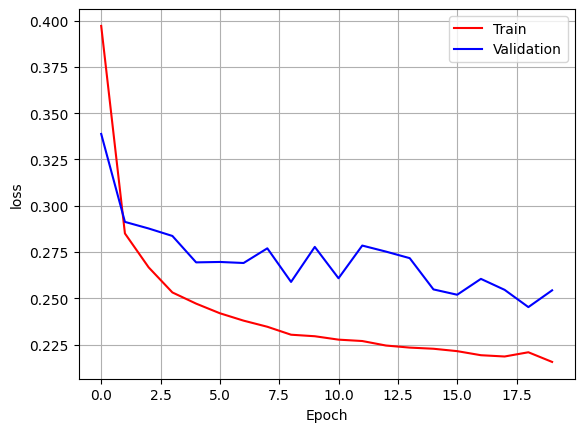

In [26]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

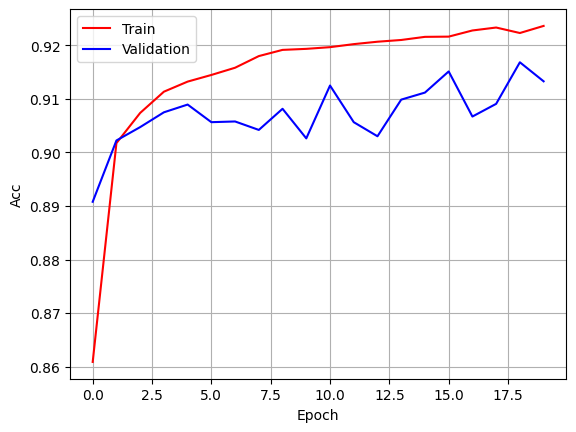

In [30]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()